In [1]:
# import altair as alt
# from vega_datasets import data
# alt.data_transformers.enable("vegafusion")

import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs

import numpy as np
import matplotlib.pyplot as plt

import xarray as xr

from scipy.stats import gamma
from scipy.optimize import curve_fit

import arviz as az
import pymc as pm

from tqdm.notebook import tqdm

# Helper function(s)

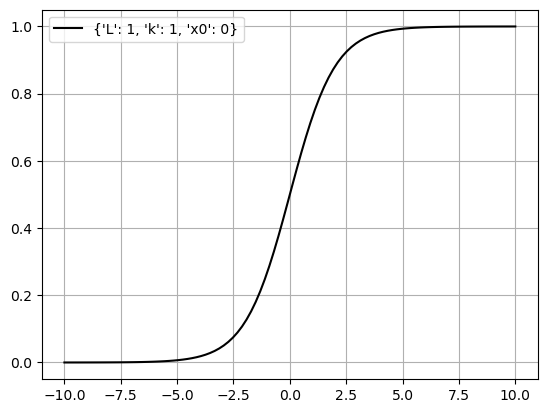

In [2]:
# Logistic curve
def logistic(x,L,k,x0):
    return L/(1+np.exp(-k*(x-x0)))

x = np.linspace(-10,10,100)
fig, ax = plt.subplots(1,1)
p = {"L": 1, "k": 1, "x0": 0}
ax.plot(x,logistic(x,**p),'k-',label=str(p))
ax.legend()
ax.grid()

In [3]:
# adjusted from https://stackoverflow.com/a/60230746/1498309
def jitter_dots(dots):
    offsets = dots.get_offsets()
    jittered_offsets = offsets
    # only jitter in the x-direction
    jittered_offsets[:, 0] += np.random.uniform(-0.3, 0.3, offsets.shape[0])
    dots.set_offsets(jittered_offsets)

def plot_compounds(df, compound_names, sst_name, ylabel=None):
    fig, ax = plt.subplots(1,1,figsize=(10,2))
    for i, column in enumerate(compound_names):
        sst = df[sst_name]
        x = np.full((len(df), 1), i)
        y = df[column]
        dots = plt.scatter(x, y, s=10, c=sst, marker='.',alpha=1,lw=0)
        jitter_dots(dots)
    plt.xticks(range(len(compound_names)), compound_names)
    xmin, xmax = plt.xlim()
    ax.set_xlim(xmin - 0.3, xmax + 0.3)  # make some room to show the jittered dots
    ax.set_ylabel(ylabel)
    ax.set_ylim(-0.1,1.1)
    cbar = plt.colorbar()
    return fig, ax

In [4]:
fnm = "../data/external/woa23_decav91C0_t00_01.nc"
ds = xr.open_dataset(fnm,decode_times=False).squeeze(drop=True).sel(depth=slice(0,250))["t_an"]
# fnm = "../data/external/woa23_decav91C0_s00_04.nc"
# ds2 = xr.open_dataset(fnm,decode_times=False).squeeze(drop=True).sel(depth=slice(0,250))["s_an"]

ds


<xarray.DataArray 't_an' (depth: 27, lat: 180, lon: 360)> Size: 7MB
[1749600 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * depth    (depth) float32 108B 0.0 5.0 10.0 15.0 ... 175.0 200.0 225.0 250.0
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius

In [5]:
df = pd.read_excel("../data/external/GDGTdata_Antarctica_220923.xlsx", sheet_name="iso modern cal",skiprows=1)

compound_names = list(df.columns[2:8].astype(str).values)
sst_name = "Sea Surface Temp"

df

,Core name,Source,GDGT-0,GDGT-1,GDGT-2,GDGT-3,Crenarchaeol,Cren',longitude,latitude,Sea Surface Temp,water depth,TEX86,Ring index
0,NBP0702-3,Tierney and Tingley 2015,0.541400,0.021900,0.006800,0.002400,0.424800,0.002600,-158.2700,-77.4700,-0.90,1081.0,0.350148,1.752300
1,NBP0702-10,Tierney and Tingley 2015,0.520800,0.015000,0.004000,0.001800,0.455500,0.002900,-108.6100,-74.1000,-1.70,730.0,0.367089,1.862000
2,NBP0702-13,Tierney and Tingley 2015,0.515200,0.020600,0.005700,0.003000,0.452700,0.002900,-134.5200,-73.9400,-1.80,470.0,0.360248,1.863400
3,NBP0702-15,Tierney and Tingley 2015,0.505600,0.023200,0.006400,0.002700,0.459000,0.003200,-125.8100,-72.5600,-1.60,425.0,0.346479,1.892900
4,NBP0702-22,Tierney and Tingley 2015,0.477800,0.034500,0.011300,0.003000,0.468300,0.005000,-104.0100,-71.7500,-1.80,665.0,0.358736,1.959300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,SO213/1_8-1,"Jaeshke et al., 2017",0.405664,0.057875,0.042174,0.004044,0.475397,0.014846,-95.3437,-37.4910,16.01,2171.0,0.513404,2.115326
971,SO213/1_6-1,"Jaeshke et al., 2017",0.454915,0.066376,0.044500,0.004564,0.416880,0.012765,-92.3805,-37.3560,16.05,2791.0,0.482269,1.887649
972,SO213/2_23-1,"Jaeshke et al., 2017",0.416182,0.068705,0.048834,0.004234,0.446719,0.015326,-100.6055,-36.6925,NaN,3430.0,0.498868,2.027256
973,O213/1_1-1,"Jaeshke et al., 2017",0.412693,0.068527,0.049505,0.006042,0.445106,0.018128,-85.0265,-36.2195,16.35,2806.0,0.518102,2.038597


0it [00:00, ?it/s]

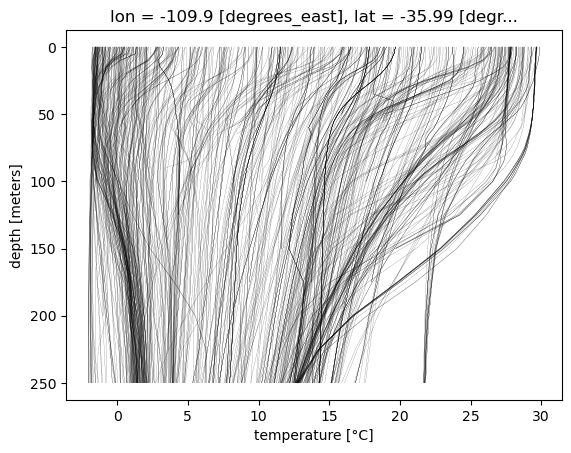

In [6]:
fig, ax = plt.subplots(1,1)

temps = []
gdgts = []

woa_data = []

for name, row in tqdm(df.iterrows()):
    lon0, lat0 = row[["longitude","latitude"]].values
    T_profile = ds.interp(lon=lon0, lat=lat0, method="nearest")
    woa_data.append(np.sum(~np.isnan(T_profile.values)))
    temps.append(T_profile.values)
    gdgts.append(row[compound_names].values)
    T_profile.plot(y='depth',ax=ax,color='k',lw=0.1)
ax.invert_yaxis()
ax.set_xlabel("temperature [°C]")
df["woa_data"] = woa_data


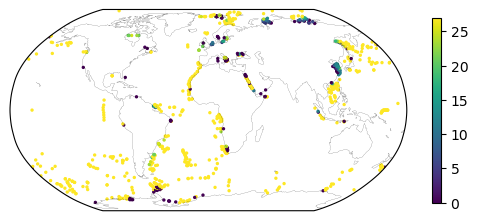

In [7]:
fig, ax = plt.subplots(1,1, subplot_kw={"projection": ccrs.Robinson()})
ax.coastlines(lw=0.1)
ax.set_global()

im = ax.scatter(df["longitude"],df["latitude"],c=df["woa_data"],s=2,transform=ccrs.PlateCarree())
plt.colorbar(im,ax=ax, shrink=0.5)

Core name                        GeoB10718-3
Source              Tierney and Tingley 2015
GDGT-0                                 0.347
GDGT-1                                 0.066
GDGT-2                                 0.039
GDGT-3                                 0.013
Crenarchaeol                           0.525
Cren'                                   0.01
longitude                             18.058
latitude                              39.693
Sea Surface Temp                        18.9
water depth                            219.0
TEX86                               0.484375
Ring index                             2.323
woa_data                                  27
Name: 546, dtype: object

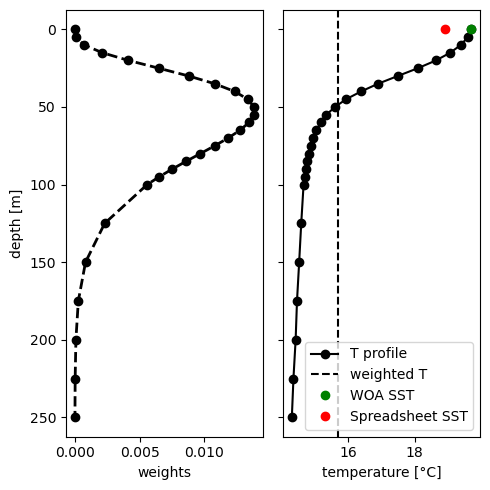

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(5,5), sharey=True)

a = 4.5
b = 15
z = ds.depth
weights = gamma.pdf(z, a, scale=b)

ax[0].plot(weights, z, 
       'ko--', lw=2, label='gamma pdf')
ax[0].invert_yaxis()
# ax[0].set_ylim(255,-5)
ax[0].set_xlabel("weights")
ax[0].set_ylabel("depth [m]")

idx = 546
display(df.iloc[idx])
ax[1].plot(temps[idx],z,'ko-',label='T profile')
valid = ~np.isnan(temps[idx])
T_avg = np.average(temps[idx][valid],weights=weights[valid]/np.sum(weights[valid]))
ax[1].axvline(T_avg,color='k',ls='--',label='weighted T')
ax[1].plot(temps[idx][0],z[0], 'go', label='WOA SST')
ax[1].plot(df.iloc[idx]["Sea Surface Temp"],z[0], 'ro', label='Spreadsheet SST')

ax[1].set_xlabel("temperature [°C]")
ax[1].legend()
fig.tight_layout()

# Synthetic data

- *GDGT-0*, *GDGT-1*, *GDGT-2*, *GDGT-3*, *Crenarchaeol*, *Cren'* are *Dirichlet*-distributed, with a shape parameter $a$ of length 6.
- The $a$'s depend on temperature $\hat{T}$ and follow *logistic* function (S curves) with parameters $L$, $k$, and $T_0$
  $$a_i(\hat{T}) = \frac{L_i}{(1+e^{-k_i(\hat{T}-T_{0,i})})} \quad \text{with} \quad i \in \{1,2,3,4,5,6\}$$
- Temperature $\hat{T}$ is the depth-averaged seawater temperature with *Gamma*-distributed weights with (global) parameters $\alpha$ and $\beta$.

In [10]:
rng = np.random.default_rng(1234)

N_GDGT = 6
# L = rng.lognormal(2,1,size=N_GDGT)
L = np.array([9,1,1,0.2,8,0.5])*20
print(f"{L = }")

# k = rng.normal(loc=0,scale=0.02, size=N_GDGT)
k = np.array([-0.1,0.02,0.02,0.05,0.02,0.05])
print(f"{k = }")

T0 = rng.normal(loc=20,scale=2, size=N_GDGT)
print(f"{T0 = }")

T_sigma = rng.lognormal(1,2)
T_sigma = 5
print(f"{T_sigma = }")

# a = rng.lognormal(1,0.1,size=N_GDGT)
# print(f"{a = }")

alpha = rng.normal(loc=5,scale=2)
alpha = 4.5
print(f"{alpha = }")

beta = rng.normal(loc=15,scale=3)
beta = 15
print(f"{beta = }")

L = array([180.,  20.,  20.,   4., 160.,  10.])
k = array([-0.1 ,  0.02,  0.02,  0.05,  0.02,  0.05])
T0 = array([16.79232639, 20.12819983, 21.48178259, 20.30523839, 21.72748778,
       25.82619845])
T_sigma = 5
alpha = 4.5
beta = 15


In [11]:
weights = gamma.pdf(z, alpha, scale=beta)

use_sst = True

N_RECORDS = len(temps)
T_hats = []
GDGT_real = []
for idx in tqdm(range(N_RECORDS)):
    if use_sst:
        this_T_hat = temps[idx][0]
        T_hats.append(this_T_hat)
        GDGT_real.append(gdgts[idx])
    else:
        valid = ~np.isnan(temps[idx])
        if sum(valid)>1:
            this_T_hat = np.average(temps[idx][valid],weights=weights[valid]/np.sum(weights[valid]))
            T_hats.append(this_T_hat)
            GDGT_real.append(gdgts[idx])
    # else:
        # print(idx)
GDGT_real = np.array(GDGT_real)

  0%|          | 0/975 [00:00<?, ?it/s]

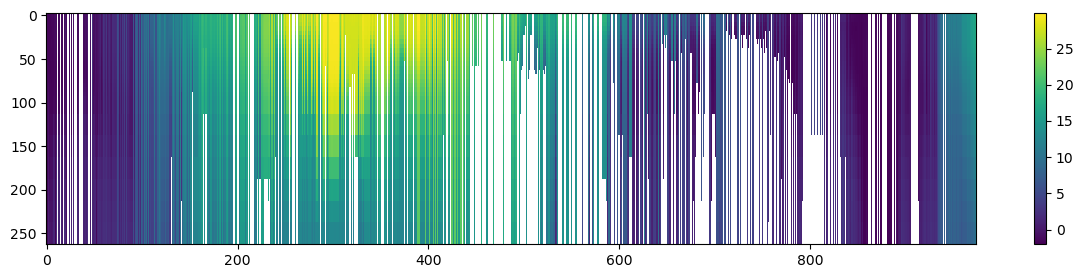

In [12]:
fig, ax = plt.subplots(1,1,figsize=(15,3))
XX, YY = np.meshgrid(np.arange(N_RECORDS),z)
im  = ax.pcolormesh(XX,YY,np.array(temps).T)
plt.colorbar(im,ax=ax)
ax.invert_yaxis()

In [13]:
synthetic_proxy_names = [f"SP{i}" for i in range(N_GDGT)]
a = {}
for i in tqdm(range(N_GDGT)):
    this_name = synthetic_proxy_names[i]
    this_T_hats = rng.normal(T_hats,T_sigma)
    a[this_name] = logistic(this_T_hats,L[i],k[i],T0[i])


  0%|          | 0/6 [00:00<?, ?it/s]

In [14]:
df_a = pd.DataFrame(a)
# display(df_a)

# The rows in `df_a` are the shape coefficients for the *Dirichlet* distribution
synth_data = []
for _,row in df_a.iterrows():
    synth_data.append(rng.dirichlet(row.values))

df_synth = pd.DataFrame(synth_data,columns=synthetic_proxy_names)
df_synth[sst_name] = T_hats

display(df_synth)

,SP0,SP1,SP2,SP3,SP4,SP5,Sea Surface Temp
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.670764,0.029422,0.044472,0.009611,0.241622,0.004109,-1.225110
2,0.629075,0.070560,0.023841,0.000430,0.272118,0.003976,-1.539810
3,0.627380,0.037688,0.036083,0.007461,0.285337,0.006051,-1.554700
4,0.673653,0.034907,0.017491,0.000390,0.269888,0.003671,-1.580100
...,...,...,...,...,...,...,...
970,0.565164,0.040146,0.043876,0.001632,0.332241,0.016941,15.852209
971,0.610345,0.036670,0.019950,0.008979,0.316962,0.007095,15.926610
972,0.501085,0.057734,0.042287,0.010517,0.370724,0.017652,16.648800
973,0.255662,0.030714,0.070348,0.030003,0.599884,0.013388,16.396290


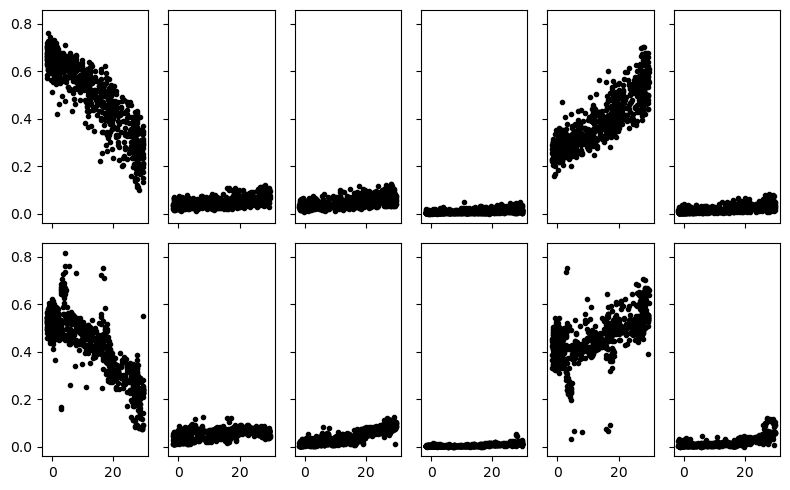

In [15]:
fig, ax = plt.subplots(2,6, sharex=True, sharey=True, figsize=(8,5))
for i in range(6):
    this_synth = synthetic_proxy_names[i]
    ax[0,i].plot(T_hats, df_synth[this_synth],'k.')
    # ax[0,i].set_ylabel(this_synth)

    # this_real = compound_names[i]
    # y = df[this_real].dropna().values
    # print(SST.shape,y.shape)
    ax[1,i].plot(T_hats,GDGT_real[:,i],'k.')
    # ax[1,i].set_ylabel(this_real)
fig.tight_layout()

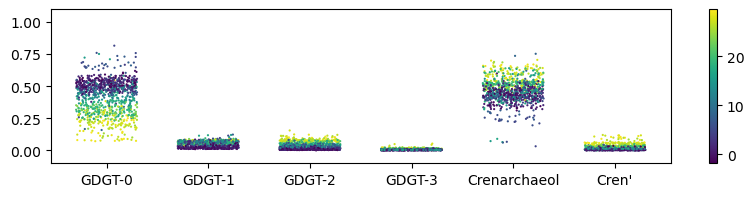

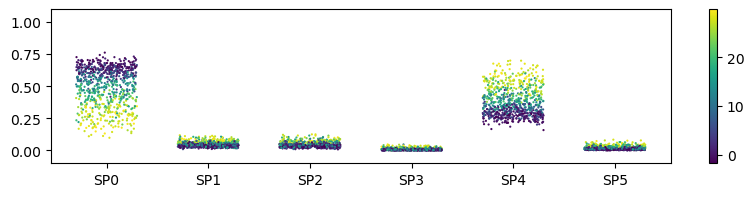

In [16]:
fig, ax = plot_compounds(df, compound_names, sst_name)
fig, ax = plot_compounds(df_synth, synthetic_proxy_names, sst_name)